In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import random
import time
import cv2
import os
from scipy import ndimage
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Input
from tensorflow.keras.layers import Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model

2024-02-17 09:43:53.294687: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-17 09:43:53.294817: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-17 09:43:53.568236: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
dir_root = '/kaggle/input/bone-age-dataset/'
output_root = '/kaggle/working/'

training_root = 'Bone Age Training Set/Bone Age Training Set/'
validation_root = 'Bone Age Validation Set/Bone Age Validation Set/'
test_root = 'Bone Age Test Set/Bone Age Test Set/'

images_path = 'Images/'
data_path = 'Dataset.csv'
data_test_path = 'Dataset.xlsx'

#We define the paths related to the images
training_images_path = dir_root + training_root + images_path
validation_images_path = dir_root + validation_root + images_path
test_images_path = dir_root + test_root + images_path

#We define the paths related to the dataset
training_data_path = dir_root + training_root + data_path
validation_data_path = dir_root + validation_root + data_path
test_data_path = dir_root + test_root + data_test_path

In [3]:
train = pd.read_csv(training_data_path)
val = pd.read_csv(validation_data_path)
test= pd.read_excel(test_data_path)
#We drop the column related to the gender
train.drop(columns=["male"], inplace=True)
val.drop(columns=["male"], inplace=True)
test.drop(columns=["Sex"], inplace=True)


val.rename(columns={"Image ID": "id"}, inplace=True)
val.rename(columns={"Bone Age (months)": "boneage"}, inplace=True)
test.rename(columns={"Case ID": "id"}, inplace=True)
test.rename(columns={"Ground truth bone age (months)": "boneage"}, inplace=True)

In [4]:
#oldest child in the dataset
print("Max age: " + str(train["boneage"].max()) + " months")

#youngest child in the dataset
print("Min age: " + str(train["boneage"].min()) + " months")

#mean age is
mean_bone_age = train["boneage"].mean()
print("mean: " + str(mean_bone_age))

#median bone age
print("median: " +str(train["boneage"].median()))

#standard deviation of boneage
std_bone_age = train["boneage"].std()

Max age: 228 months
Min age: 1 months
mean: 127.3207517246848
median: 132.0


Text(0.5, 1.0, 'Distribution of the children for the age')

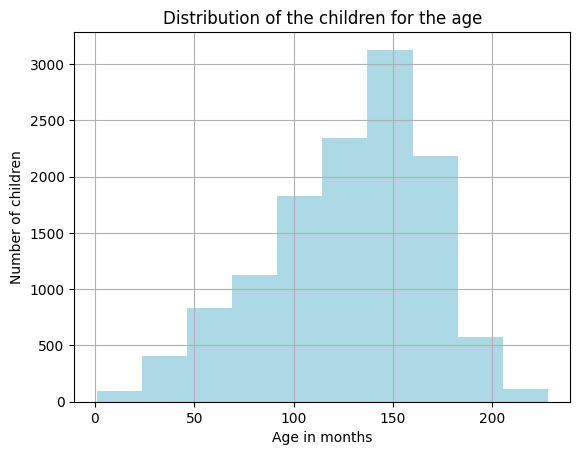

In [5]:
train["boneage"].hist(color = "lightblue")
plt.xlabel("Age in months")
plt.ylabel("Number of children")
plt.title("Distribution of the children for the age")

In [6]:
def generate_path(row):
    return training_images_path + str(row['id']) + '.png'

train['path'] = train.apply(generate_path, axis=1)

(2920, 2320, 3)


Text(0.5, 1.0, 'y = 180')

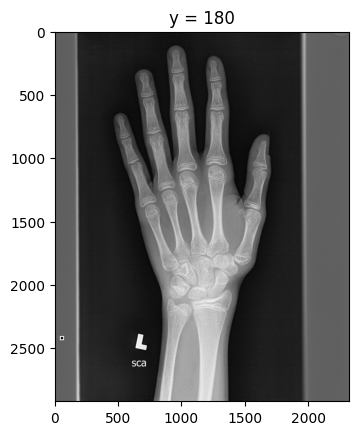

In [7]:
index =1263

image_path = train.loc[:,"path"][index]
#We upload and read the image
img = cv2.imread(image_path)
print(img.shape)
plt.imshow(img)
plt.title("y = " +str(np.squeeze(train.iloc[index, 1])))

In [8]:
def generate_path(row):
    return validation_images_path + str(row['id']) + '.png'

val['path'] = val.apply(generate_path, axis=1)

In [9]:
def generate_path(row):
    return test_images_path + str(row['id']) + '.png'

test['path'] = test.apply(generate_path, axis=1)

In [10]:
def apply_clahe(image, cliplimit=4.0, tilegridsize=(8,8)):
    image = image.astype("uint8")
    if len(image.shape) == 2:
        image = np.expand_dims(image, axis=-1)
    clahe = cv2.createCLAHE(clipLimit=cliplimit, tileGridSize=tilegridsize)
    clahe_image = clahe.apply(image[:,:,0]) 
    
    return np.expand_dims(clahe_image, axis=-1)

In [11]:
image_augmentator_train=tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=apply_clahe
)

In [12]:
image_augmentator_test=tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=apply_clahe
)

In [13]:
batch_size = 40

train_dataset = image_augmentator_train.flow_from_dataframe(
    dataframe=train,
    directory=None,
    x_col="path",
    y_col="boneage",
    target_size=(256, 256),                             
    color_mode='grayscale',
    batch_size=batch_size,
    seed=42,
    shuffle=True,
    classes=None,
    class_mode='other',
    rescale=1/255)                                     

val_dataset = image_augmentator_test.flow_from_dataframe(
    dataframe=val,
    directory=None,
    x_col="path",
    y_col="boneage",
    target_size=(256, 256),
    color_mode='grayscale',
    batch_size=batch_size,
    seed=42,
    shuffle=False,
    classes=None,
    class_mode='other',
    rescale=1/255)

test_dataset = image_augmentator_test.flow_from_dataframe(
    dataframe=test,
    directory=None,
    x_col="path",
    y_col="boneage",
    target_size=(256, 256),
    color_mode='grayscale',
    batch_size=batch_size,
    seed=42,
    shuffle=False,
    classes=None,
    class_mode='other',
    rescale=1/255)

Found 12611 validated image filenames.
Found 1425 validated image filenames.
Found 0 validated image filenames.


/opt/conda/lib/python3.10/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 200 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  warnings.warn(


In [14]:
def generate_path(row):
    return test_images_path + str(row['id']) + '.png'

test['path'] = test.apply(generate_path, axis=1)

In [15]:
test_dataset = image_augmentator_test.flow_from_dataframe(
    dataframe=test,
    directory=None,
    x_col="path",
    y_col="boneage",
    target_size=(256, 256),
    color_mode='grayscale',
    batch_size=batch_size,
    seed=42,
    shuffle=False,
    classes=None,
    class_mode='other',
    rescale=1/255)

Found 200 validated image filenames.


In [16]:
train_steps = int(np.ceil(len(train)/batch_size))
val_steps = int(np.ceil(len(val)/batch_size))
test_steps = int(np.ceil(len(test)/batch_size))

**SqueezeNet**

In [17]:
def fire_module(x, squeeze=16, expand=64):

    x = Conv2D(squeeze, (1, 1), padding='valid', activation = "relu")(x)

    left = Conv2D(expand, (1, 1), padding='valid', activation = "relu")(x)

    right = Conv2D(expand, (3, 3), padding='same', activation = "relu")(x)
    x = tf.keras.layers.concatenate([left, right])
    return x

In [18]:
def SqueezeNet(input_shape):
    
    img_input = Input(shape=input_shape)

    x = Conv2D(64, (3, 3), strides=(2, 2), padding='valid', activation = "relu", name='conv1')(img_input)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool1')(x)

    x = fire_module(x, squeeze=16, expand=64)
    x = fire_module(x, squeeze=16, expand=64)
    x = fire_module(x, squeeze=32, expand=128)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool3')(x)
    
    x = fire_module(x, squeeze=32, expand=128)
    x = fire_module(x, squeeze=48, expand=192)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool5')(x)

    x = fire_module(x, squeeze=48, expand=192)
    x = fire_module(x, squeeze=48, expand=192)
    x = fire_module(x, squeeze=64, expand=256)
    x = fire_module(x, squeeze=64, expand=256)
    x = Dropout(0.2, name='drop9')(x)

    x = Conv2D(1000, (1, 1), padding='valid', activation = "relu", name='conv10')(x)
    x = GlobalAveragePooling2D()(x)
    x = Dense(1, activation = "linear", name="loss")(x)
    

    model = Model(inputs = img_input, outputs= x, name='squeezenet')
    
    return model

In [19]:
model_3 = SqueezeNet((256, 256, 1))

# Compile the model
model_3.compile(optimizer="adam", loss="mean_squared_error", metrics=[tf.keras.metrics.MeanAbsoluteError()])

In [20]:
model_3.summary()

Model: "squeezenet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv1 (Conv2D)              (None, 127, 127, 64)         640       ['input_1[0][0]']             
                                                                                                  
 pool1 (MaxPooling2D)        (None, 63, 63, 64)           0         ['conv1[0][0]']               
                                                                                                  
 conv2d (Conv2D)             (None, 63, 63, 16)           1040      ['pool1[0][0]']               
                                                                                         

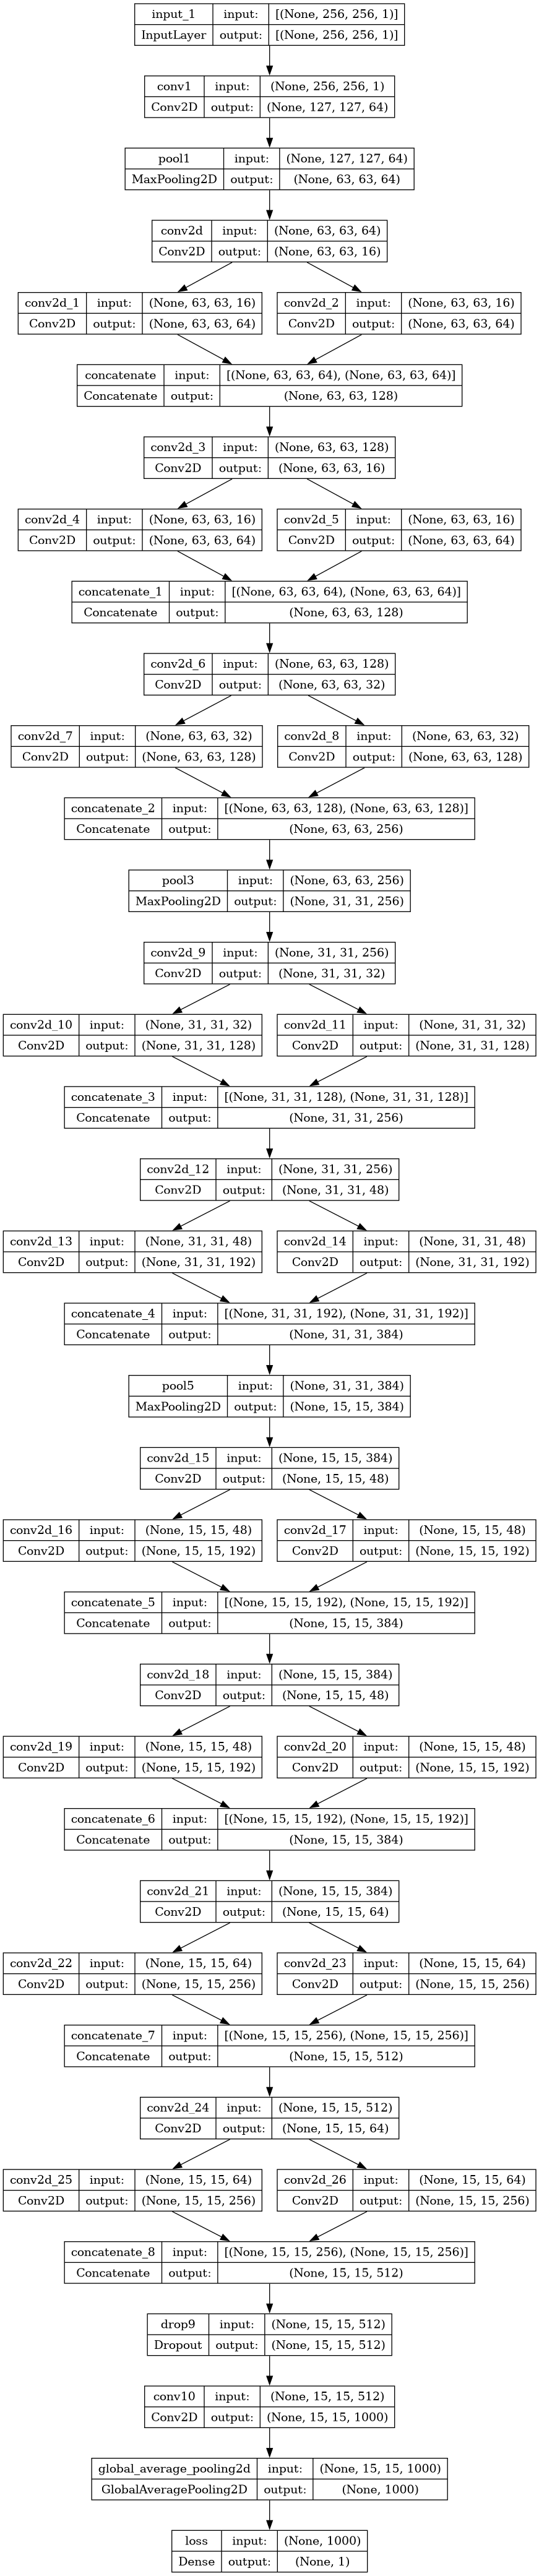

In [21]:
tf.keras.utils.plot_model(model_3, show_shapes=True)

In [22]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=16, restore_best_weights=True)

In [23]:
model_3_history = model_3.fit(train_dataset, epochs=70, callbacks=callback, steps_per_epoch=train_steps,  validation_data=val_dataset, validation_steps=val_steps)

Epoch 1/70


2024-02-17 09:44:46.947286: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insqueezenet/drop9/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1708163094.465636      75 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


316/316 [==============================] - 640s 2s/step - loss: 3358.1255 - mean_absolute_error: 44.8721 - val_loss: 1703.7255 - val_mean_absolute_error: 32.6270
Epoch 2/70
316/316 [==============================] - 439s 1s/step - loss: 1744.1804 - mean_absolute_error: 34.0076 - val_loss: 1616.4049 - val_mean_absolute_error: 32.4222
Epoch 3/70
316/316 [==============================] - 439s 1s/step - loss: 1673.4296 - mean_absolute_error: 33.2823 - val_loss: 1606.9586 - val_mean_absolute_error: 32.2920
Epoch 4/70
316/316 [==============================] - 438s 1s/step - loss: 1664.8418 - mean_absolute_error: 33.1404 - val_loss: 1565.9811 - val_mean_absolute_error: 32.5277
Epoch 5/70
316/316 [==============================] - 445s 1s/step - loss: 1662.8779 - mean_absolute_error: 33.1058 - val_loss: 1579.7733 - val_mean_absolute_error: 32.5322
Epoch 6/70
316/316 [==============================] - 442s 1s/step - loss: 1642.1718 - mean_absolute_error: 32.8473 - val_loss: 1828.1722 - val_me

In [24]:
model_3.save("SqueezeNet.h5")

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [25]:
def plot_loss(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history["val_"+metric])
    plt.title("Model Loss - MSE")
    plt.ylabel("loss - MSE")
    plt.xlabel("epoch")
    plt.legend(["train", "val"], loc="upper right")
    plt.show()

In [26]:
def plot_MAE(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history["val_"+metric])
    plt.title("Model MAE")
    plt.ylabel("MAE")
    plt.xlabel("epoch")
    plt.legend(["train", "val"], loc="upper right")
    plt.show()

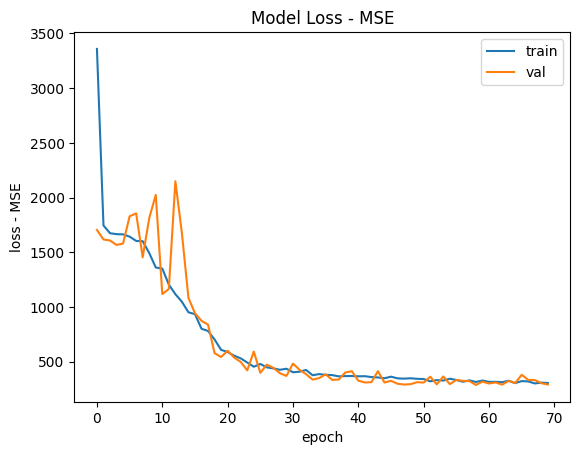

In [27]:
plot_loss(model_3_history, "loss")

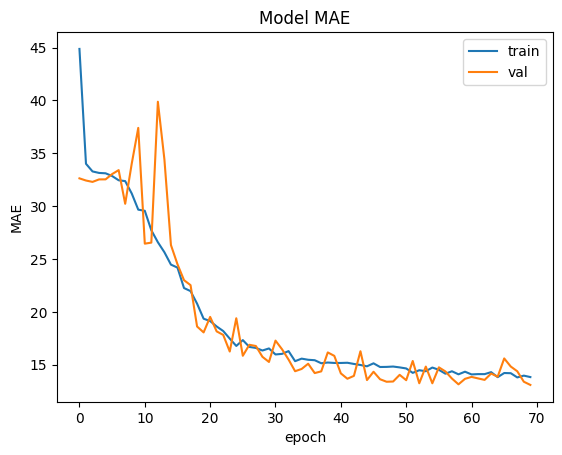

In [28]:
plot_MAE(model_3_history, "mean_absolute_error")

In [29]:
model_3_evaluation = model_3.evaluate(test_dataset, verbose="auto", steps=test_steps)
print("MSE on the Test = " + str(model_3_evaluation[0]))
print("MAE on the Test = " + str(model_3_evaluation[1]))

5/5 [==============================] - 7s 2s/step - loss: 270.8270 - mean_absolute_error: 13.1106
MSE on the Test = 270.8270263671875
MAE on the Test = 13.110613822937012


In [30]:
test_x, test_y = next(test_dataset)
model_3.load_weights('SqueezeNet.h5')
prediction = (model_3.predict(test_x, batch_size = 40, verbose = True))
test_months = (test_y)


for i in random.sample(range(len(test_x)), 4):
    print("image number: " + str(i))
    print("Age: " + str(test_months[i]))
    print(" Predicted Age: " + str(prediction[i]))

1/1 [==============================] - 0s 318ms/step
image number: 13
Age: 185.07963105601792
 Predicted Age: [173.15567]
image number: 1
Age: 169.65267756583563
 Predicted Age: [169.77945]
image number: 8
Age: 178.25193734586986
 Predicted Age: [163.7309]
image number: 22
Age: 136.76382494121708
 Predicted Age: [139.05313]
